In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy import stats
from scipy.signal import hilbert,convolve,hann
     
from sklearn.linear_model import LinearRegression

In [2]:
import sys

In [3]:
import tensorflow as tf

In [4]:
import keras
import keras.backend as K
from keras.models import Sequential,Model
from keras.layers import LSTM,Dense

Using TensorFlow backend.


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
pd.set_option('precision',30)

In [7]:
train_df=pd.read_csv('F:\\Qplus\\Kaggle\\train.csv',chunksize=5000000,iterator=True,
                     dtype={'acoustic_data':np.int16,'time_to_failure':np.float32})

In [8]:
def create_many_features(xc,seg_id=0):
    X=pd.DataFrame(index=[seg_id,])
    zc=np.fft.fft(xc)
    
    X.loc[seg_id,'mean']=xc.mean()
    X.loc[seg_id,'std']=xc.std()
    X.loc[seg_id,'max']=xc.max()
    X.loc[seg_id,'min']=xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    X.loc[seg_id, 'avg_diff'] = np.mean(np.diff(xc))
    #X.loc[seg_id, 'avg_diff_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0]) #seems do not help
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
    return X

In [9]:
#generate features for a list of acoustic data
def gen_features_list(acd_list):
    train_features=pd.DataFrame()
    for acd in acd_list:
        train_features=train_features.append(create_many_features(acd),ignore_index=True)
    #print(train_features.shape)
    return train_features

In [10]:
def split_segments(acd_segments,ttf_segments,split_length):
    length=len(acd_segments)
    #split each complete segements into many small segments
    split_segments_index=np.array_split(np.arange(length),length//split_length)
    print('the length of this segments is %d'%len(split_segments_index))
    acd_split=[]
    ttf_split=pd.Series()
    for indices in split_segments_index:
        acd_split.append(pd.Series(acd_segments[indices]))
        ttf_split=ttf_split.append(pd.Series(ttf_segments[indices][-1]),ignore_index=True)
    #print(len(acd_split))
    return acd_split,ttf_split

In [11]:
def add_trend_feature(arr,abs_values=False):
    index=np.arange(len(arr))
    if abs_values:
        arr=np.abs(arr)
    lr=LinearRegression()
    lr.fit(index.reshape(-1,1),arr)
    return lr.coef_[0]

In [12]:
def classic_sta_lta(x,length_sta,length_lta):
    sta=np.cumsum(x**2)
    sta=np.require(sta,dtype=np.float)
    
    lta=sta.copy()
    
    sta[length_sta:]=sta[length_sta:]-sta[:-length_sta]
    sta/=length_sta
    
    lta[length_lta:]=lta[length_lta:]-lta[:-length_lta]
    lta/=length_lta
    
    sta[:length_sta-1]=0
    
    dtiny=np.finfo(0.0).tiny
    idx=lta<dtiny
    lta[idx]=dtiny
    return sta/lta
    
    
    

In [ ]:

train_X=pd.DataFrame()
train_y=pd.Series()
acd_to_be_extended=np.array([])
ttf_to_be_extended=np.array([])
last=math.inf
split_length=100000
for chunk in train_df:
    acd=chunk.acoustic_data.values
    ttf=chunk.time_to_failure.values
    #split_index=[]   #record the index for segmentation
    split_index=np.array([])
    if ttf[0]>last:
        #split_index.append[0]
        acd_split,ttf_split=split_segments(acd_to_be_extended,ttf_to_be_extended,split_length)      
        train_X=train_X.append(gen_features_list(acd_split),ignore_index=True)
        train_y=train_y.append(ttf_split,ignore_index=True)
        acd_to_be_extended=np.array([])
        ttf_to_be_extended=np.array([])
        
    find_split=ttf[1:]>ttf[:-1]
    #split_index.append(np.where(find_split))
    split_index=np.append(split_index,np.where(find_split))
    length=len(split_index.tolist())
    if length!=0:     #which means a segment split exists
        print(length)
        print(split_index)
        acd_to_be_extended=np.append(acd_to_be_extended,
                                     acd[:int(split_index[0]+1)])
        ttf_to_be_extended=np.append(ttf_to_be_extended,ttf[:int(split_index[0]+1)])
        acd_split,ttf_split=split_segments(acd_to_be_extended,ttf_to_be_extended,split_length)
        train_X=train_X.append(gen_features_list(acd_split),ignore_index=True)
        train_y=train_y.append(ttf_split,ignore_index=True)
        #print(train_X.describe())
        #print(train_y.describe())
        acd_to_be_extended=np.array([])
        ttf_to_be_extended=np.array([])
        
        for i in range(length-1):
            acd_to_be_extended=acd[int(split_index[i])+1:int(split_index[i+1])+1]
            ttf_to_be_extended=ttf[int(split_index[i])+1:int(split_index[i+1])+1]
            acd_split,ttf_split=split_segments(acd_to_be_extended,ttf_to_be_extended,split_length)
            train_X=train_X.append(gen_features_list(acd_split),ignore_index=True)
            train_y=train_y.append(ttf_split,ignore_index=True)
            acd_to_be_extended=np.array([])
            ttf_to_be_extended=np.array([])
        acd_to_be_extended=acd[int(split_index[-1]):]
        ttf_to_be_extended=ttf[int(split_index[-1]):]
        
    else:
        acd_to_be_extended=np.append(acd_to_be_extended,acd)
        ttf_to_be_extended=np.append(ttf_to_be_extended,ttf)
    last=ttf[-1]

1
[656573.]
the length of this segments is 56
1
[85877.]
the length of this segments is 444


In [14]:
train_X.shape

(6211, 145)

In [19]:
train_X.describe()

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
count,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.00000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,...,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000,6211.000000000000000000000000000000
mean,4.521794057319453052912194834789,6.430987478526413170243358763400,139.49798744163581432076171040535,-126.210594107229113092216721270233,4.723393978425361794393211312126,2091.845376771060273313196375966072,452852.090632981446105986833572387695,-19064.761164248695422429591417312622,-0.000000000000000094879746660814,1439.203501627237528737168759107590,...,0.245409972376859408793592365328,5.493421510223812198603354772786,3.601909515375931736258507953607,3.957356815327635057855104605551,4.125933191112539866196584625868,4.912264981484448789217367448146,5.086996092416658399315565475263,0.000000006803709005935721477664,49572.743164466824964620172977447510,5.493421510223812198603354772786
std,0.262287060160258322927262497615,8.657797853724391146101879712660,228.15484357098850409784063231200,221.690000058802752391784451901913,6.335885461568502741158681601519,1871.694929737956954340916126966476,26392.862218167429091408848762512207,23951.327619581265025772154331207275,0.000000000000009599428945017010,1937.983858970942947053117677569389,...,0.160087043893305663866399868311,2.601413582855253814329898887081,1.972359232628741576576203442528,0.497418705190214527345204942321,0.286149452875349152858319712323,0.281985540624572039725137528876,0.632900619272082298749637629953,0.000003910246556921267932504811,134.127044024641975283884676173329,2.601413582855253814329898887081
min,3.586511581469648657360949073336,2.763379844684633379614524528733,20.00000000000000000000000000000,-5515.000000000000000000000000000000,-81.999999999999985789145284797996,1376.742713799495959392515942454338,359225.000000000000000000000000000000,-527625.670732867205515503883361816406,-0.000000000000503927246615231341,617.681552258119495490973349660635,...,0.144761446695028578313113598597,4.112000000000000099475983006414,-48.777999999999998692601366201416,-6.466919999999999113526882865699,1.461999999999999966249220051395,3.879000000000000003552713678801,3.971000000000000085265128291212,-0.000039589961117002482528671320,49083.852842218948353547602891921997,4.112000000000000099475983006414
25%,4.350461710507792290059114748146,4.384949846821973196142607775982,78.00000000000000000000000000000,-137.000000000000000000000000000000,2.000000000000005329070518200751,1740.888997017793144550523720681667,435588.000000000000000000000000000000,-21297.226620579756854567676782608032,-0.000000000000001455053297174572,981.300540082976908706768881529570,...,0.212309998954476719656980776563,5.081999999999999850786025490379,3.524999999999999911182158029987,3.798999999999999932498440102790,3.951999999999999957367435854394,4.729000000000000092370555648813,4.873999999999999666044914192753,-0.000002561981897972559492864105,49486.210439533824683167040348052979,5.081999999999999850786025490379
50%,4.525091236314552567421287676552,5.490830675311533681792752759065,108.00000000000000000000000000000,-95.000000000000000000000000000000,4.999999999999965361041631695116,1890.333568447643074250663630664349,453228.000000000000000

In [126]:
test_X_seg_ids.head()

,time_to_failure
seg_id,
seg_00030f,0.0
seg_0012b5,0.0
seg_00184e,0.0
seg_003339,0.0
seg_0042cc,0.0


In [15]:
test_X_seg_ids=pd.read_csv('F:\\Qplus\\Kaggle\\sample_submission.csv',dtype={'time_to_failure':np.float32},index_col='seg_id')

In [17]:
test_X=pd.DataFrame()
for seg_id in test_X_seg_ids.index.values:
    #print(type(seg_id))
    seg_data=pd.read_csv('F:\\Qplus\\Kaggle\\test\\'+seg_id+'.csv',dtype={'acoustic_data':np.float32})
    test_X=test_X.append(create_many_features(seg_data.acoustic_data,seg_id=seg_id),ignore_index=True)

In [18]:
test_X.shape

(2624, 145)

In [20]:
Merged_X=pd.concat((train_X,test_X),ignore_index=True)

In [37]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(Merged_X)
train_X_scaled=scaler.transform(train_X)

In [38]:
test_X_scaled=scaler.transform(test_X)

In [39]:
import lightgbm as lgb

In [40]:
params={'num_leaves':51,'min_data_in_leaf':10,'objective':'regression','max_depth':-1,'learing_rate':0.001,
        'boosting':'gbdt',"feature_fraction": 0.91,"bagging_freq": 1,"bagging_fraction": 0.91,"bagging_seed": 42,
         "metric": 'mae',"lambda_l1": 0.1,"verbosity": -1,"nthread": -1,"random_state": 42}

In [41]:
oof=np.zeros(len(train_X_scaled))
predictions=np.zeros(len(test_X))
feature_importance_df=pd.DataFrame()

In [43]:
from sklearn.model_selection import KFold
n_splits=5
kf=KFold(n_splits)
for fold,(train_index,val_index) in enumerate(kf.split(train_X_scaled,train_y)):
    strlog='fold{}'.format(fold)
    print(strlog)
    
    X_tr,X_val=train_X_scaled[train_index],train_X_scaled[val_index]
    y_tr,y_val=train_y.iloc[train_index],train_y.iloc[val_index]
    
    model=lgb.LGBMRegressor(**params,n_estimators=2000,n_job=-1)
    model.fit(X_tr,y_tr,eval_set=[(X_tr,y_tr),(X_val,y_val)],eval_metric='mae',verbose=1000,early_stopping_rounds=500)
    
    oof[val_index]=model.predict(X_val,num_iteration=model.best_iteration_)
    
    fold_importance_df=pd.DataFrame()
    fold_importance_df['feature']=train_X.columns.values
    fold_importance_df['importance']=model.feature_importances_[:len(train_X.columns.values)]
    fold_importance_df['fold']=fold+1
    feature_importance_df=pd.concat([feature_importance_df,fold_importance_df],axis=0)
    #predictions
    predictions +=model.predict(test_X_scaled,num_iteration=model.best_iteration_)/kf.n_splits

fold0
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[458]	valid_0's l1: 0.0556234	valid_1's l1: 2.09737
fold1
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[116]	valid_0's l1: 0.702248	valid_1's l1: 2.48001
fold2
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[17]	valid_0's l1: 1.70581	valid_1's l1: 2.49356
fold3
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[35]	valid_0's l1: 1.58105	valid_1's l1: 1.45695
fold4
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[8]	valid_0's l1: 2.12088	valid_1's l1: 2.53798


In [46]:
cols=feature_importance_df[['feature','importance']].groupby('feature').mean().sort_values(by='importance',ascending=False)[:200].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')

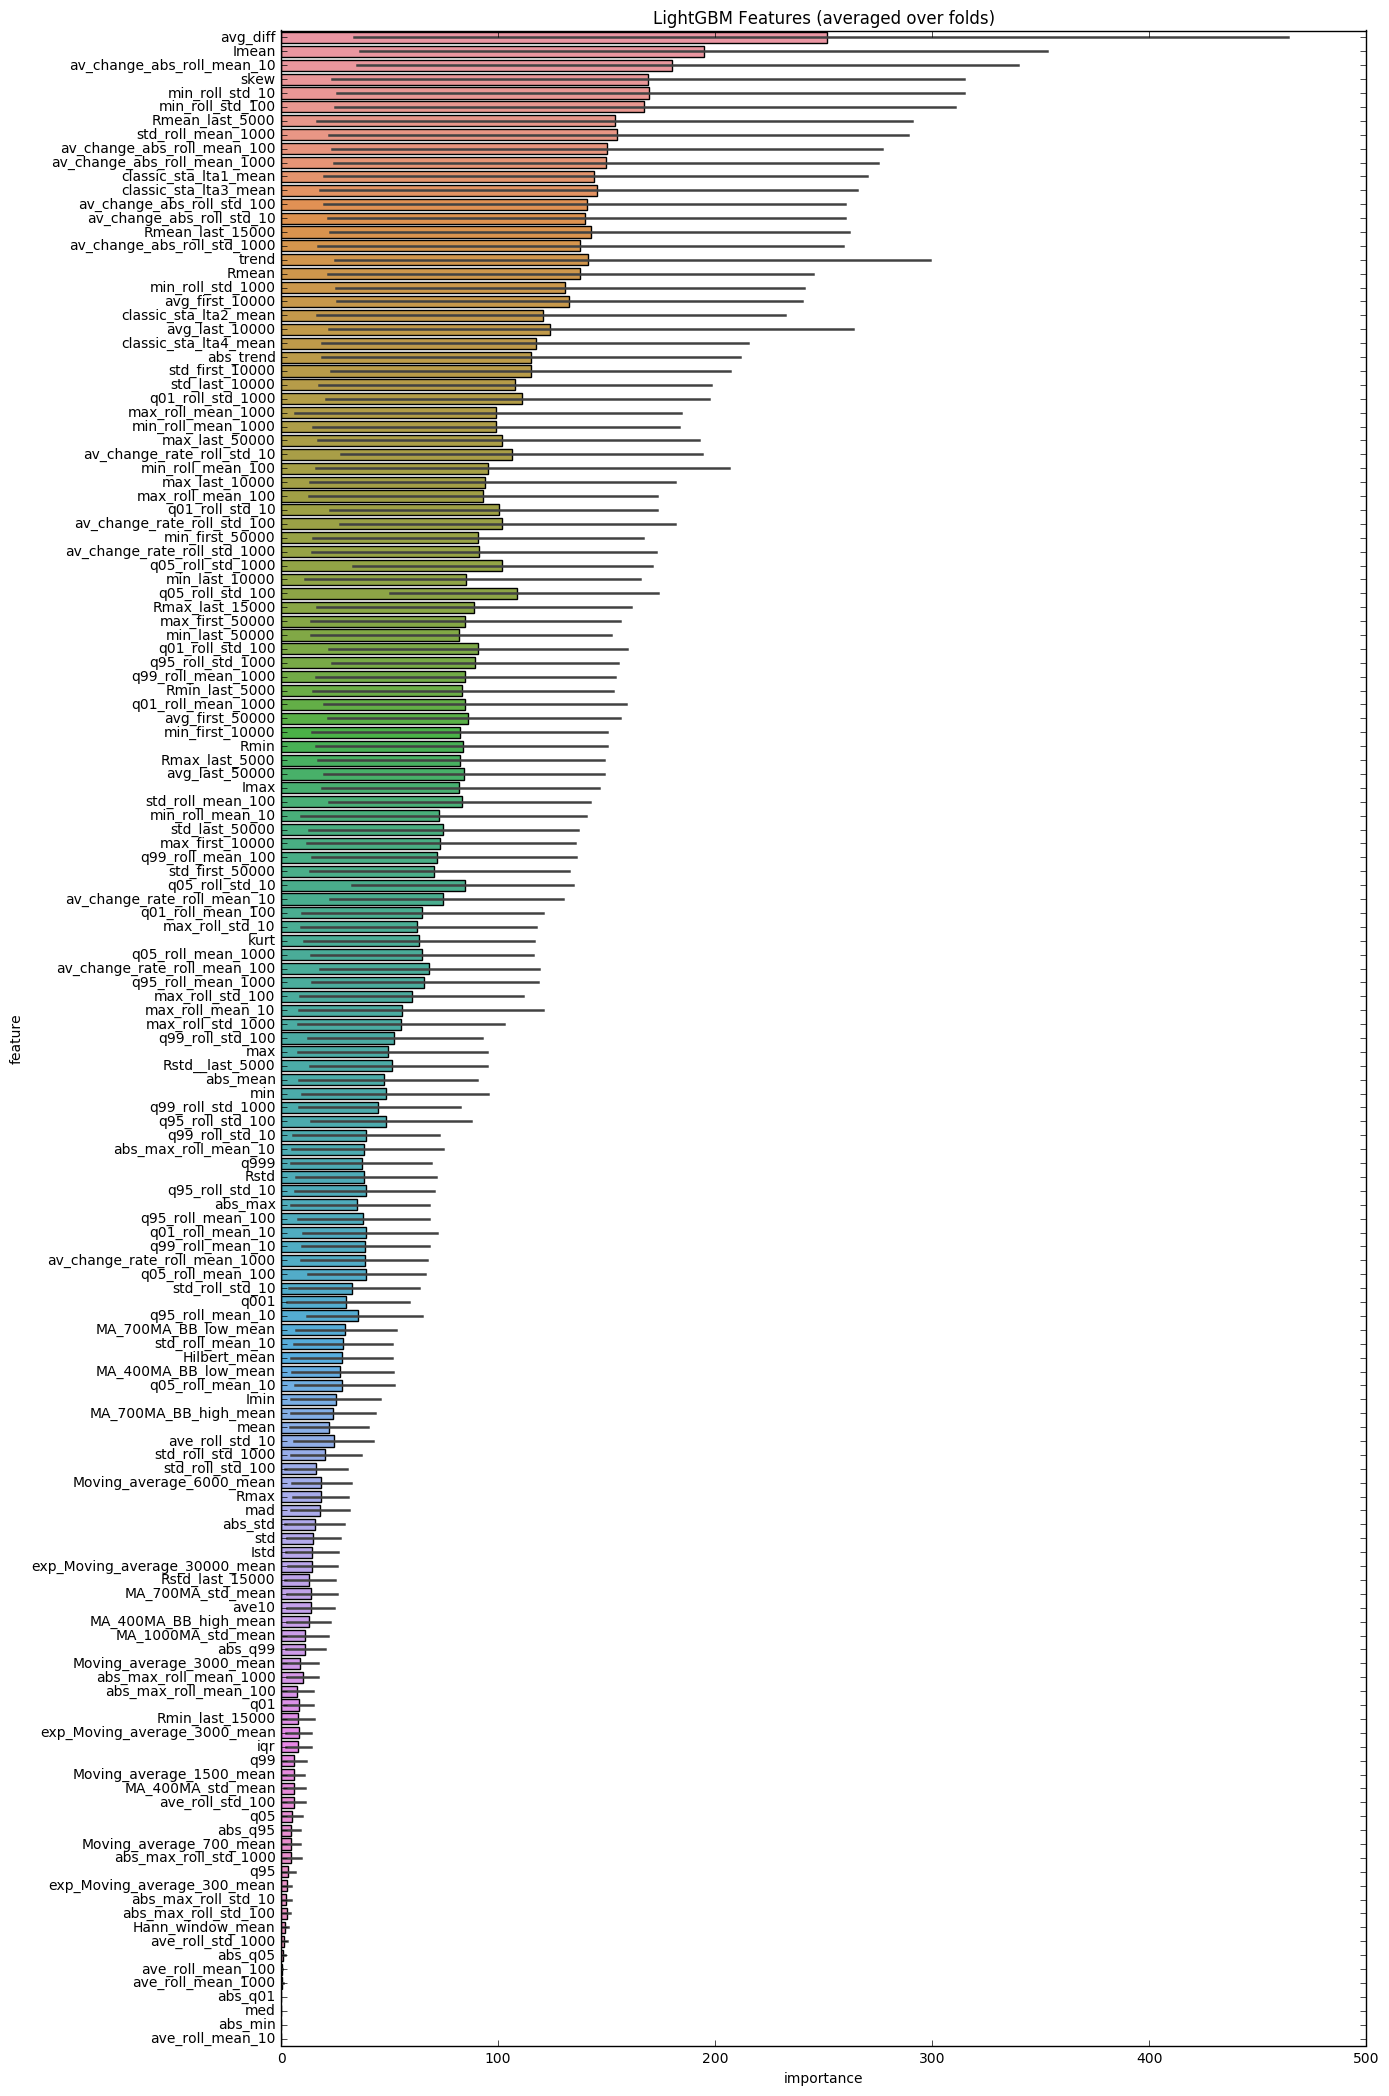

In [47]:
plt.show()

In [48]:
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split

In [49]:
TRAIN_X,VALID_X,TRAIN_y,VALID_y=train_test_split(train_X_scaled,train_y,test_size=0.3,random_state=89)

In [ ]:
parameters = {
              'max_depth': [10, 15, 20, 25, 30, 35],'num_leaves':[5,8,12,20,30,45,70]
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
              'feature_fraction': [0.6, 0.8, 0.95],
              'bagging_fraction': [0.6, 00.8, 0.95],
              'bagging_freq': [2, 4, 6, 8],
              'lambda_l1': [0, 0.1, 0.4, 0.5, 0.6],
              'lambda_l2': [0, 10, 15, 35, 40],
              'cat_smooth': [1, 10, 15, 20, 35]
}

In [104]:
parameters = {'max_depth': [3, 5, 6, 8, 10, 15,25,35],'num_leaves':[10,20,50,100],
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],'min_data_in_leaf':[5,15,30,50,75],
             'lambda_l1': [0, 0.1, 0.4, 0.5, 0.6],
              'lambda_l2': [0, 10, 15, 35, 40], 'cat_smooth': [1, 10, 15, 20, 35]}

In [118]:
parameters = {'max_depth': [3, 5, 6, 8, 10, 15,25, 40, 60],'num_leaves':[5,10,20,50,100],
           }

In [84]:
params={'num_leaves':51,'min_data_in_leaf':10,'objective':'regression','max_depth':-1,'learing_rate':0.001,
        'boosting':'gbdt',"feature_fraction": 0.91,"bagging_freq": 1,"bagging_fraction": 0.91,"bagging_seed": 42,
         "metric": 'mae',"lambda_l1": 0.1,"verbosity": -1,"nthread": -1,"random_state": 42}

In [121]:
model=lgb.LGBMRegressor(boosting='gbdt',objective='regression',max_depth=51,num_leaves=15,learning_rate=0.05,
                        metric='mae',num_iterations=2000, nthread=-1)

In [122]:
gsearch=GridSearchCV(model,param_grid=parameters,scoring='neg_mean_squared_error',cv=3)
gsearch.fit(train_X_scaled,train_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=LGBMRegressor(boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, importance_type='split', learning_rate=0.05,
       max_depth=51, metric='mae', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, ...      reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, 6, 8, 10, 15, 25, 40, 60], 'num_leaves': [5, 10, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [123]:
gsearch.best_score_

-8.89370907172839

In [124]:
gsearch.best_params_

{'max_depth': 15, 'num_leaves': 50}

In [112]:
y_predict=gsearch.predict(test_X_scaled)

In [125]:
test_X.head()

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,4.491779804229736328125,4.893698215484619140625,115.0,-75.0,3.999999999999999111821580299875,2198.344035859719042491633445024490,673767.0,-14758.442558580365584930405020713806,0.000000000000000097012768189112,1336.370644694053453349624760448933,...,0.231890979668247093625765842262,5.495000000000000106581410364015,3.774000000000000021316282072803,3.888999999999999790389892950770,4.099000000000000198951966012828,4.866999999999999992894572642399,5.000000000000000000000000000000,0.000001778523489932883730715494,74583.596158882588497363030910491943,5.495000000000000106581410364015
1,4.171153545379638671875,5.921858787536621093750,152.0,-140.0,5.000000000000001776356839400250,2289.922378597143961087567731738091,625673.0,-22626.387705690489383414387702941895,0.000000000000000691215973347425,1621.103790631555966683663427829742,...,0.230913661347393217582180113823,5.009000000000000341060513164848,3.342000000000000081712414612412,3.644000000000000127897692436818,3.790000000000000035527136788005,4.541000000000000369482222595252,4.738999999999999879207734920783,-0.000000194630872483220891052286,74346.833284796943189576268196105957,5.009000000000000341060513164848
2,4.610260009765625000000,6.947450160980224609375,248.0,-193.0,7.999999999999998223643160599750,2611.055629434194997884333133697510,691539.0,-23593.939293521973013412207365036011,-0.000000000000000873114913702011,1899.881970018137735678465105593204,...,0.247219261166618103908731995944,6.233999999999999985789145284798,3.544000000000000039079850466806,4.012999999999999900524016993586,4.214999999999999857891452847980,4.966000000000000191846538655227,5.081999999999999850786025490379,0.000000080536912751674944401245,74349.464458851696690544486045837402,6.233999999999999985789145284798
3,4.531473159790039062500,4.114318370819091796875,85.0,-93.0,2.000000000000001776356839400250,2085.543454354283767315791919827461,679721.0,-11908.537958646626066183671355247498,-0.000000000000000860988317678372,1126.745534714915038421167992055416,...,0.224908762860212857459529800508,5.445999999999999729993760411162,3.888999999999999790389892950770,4.032000000000000028421709430404,4.184000000000000163424829224823,4.910999999999999587885213259142,5.051000000000000156319401867222,0.000003899328859060399226569692,74430.046482895355438813567161560059,5.445999999999999729993760411162
4,4.128339767456054687500,5.797387123107910156250,177.0,-147.0,5.000000000000001776356839400250,2243.929923148225043405545875430107,619251.0,-24048.055869679606985300779342651367,-0.000000000000000097012768189112,1600.707499826248749741353094577789,...,0.274025292743740045420253181874,5.027000000000000135003119794419,3.357000000000000206057393370429,3.533999999999999808153461344773,3.661999999999999921840299066389,4.570000000000000284217094304040,4.870000000000000106581410364015,-0.000002939597315436245565076255,74545.727161125323618762195110321045,5.027000000000000135003119794419


In [127]:
best_model=lgb.LGBMRegressor(boosting='gbdt',objective='regression',max_depth=15,num_leaves=50,learning_rate=0.05,
                        metric='mae',num_iterations=2000, nthread=-1)
best_model.fit(train_X_scaled,train_y)

LGBMRegressor(boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, importance_type='split', learning_rate=0.05,
       max_depth=15, metric='mae', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, nthread=-1, num_iterations=2000, num_leaves=50,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [128]:
y_predict=best_model.predict(test_X_scaled,num_iteration=best_model.best_iteration_)

In [129]:
submission=pd.Series(y_predict,index=test_X_seg_ids.index)

In [130]:
submission.head()

seg_id
seg_00030f   -0.983706399252892715878715534927
seg_0012b5    0.303192479453073482353886447527
seg_00184e    2.051765970848652642644083243795
seg_003339    2.201374268260838817923286114819
seg_0042cc    4.234744013131557238693858380429
dtype: float64

In [131]:
submission.to_csv('F:\\Qplus\\Kaggle\\submission.csv',index=True)

In [132]:
submission = pd.read_csv('F:\\Qplus\\Kaggle\sample_submission.csv', index_col='seg_id')

In [133]:
submission['time_to_failure'] = y_predict

In [135]:
submission.to_csv('F:\\Qplus\\Kaggle\\submission.csv',index=True)

In [136]:
train_X_transformed=train_X_scaled.reshape(train_X_scaled.shape[0],train_X_scaled.shape[1],1)

In [137]:
train_X_transformed.shape

(6211, 145, 1)

In [150]:
LSTM_model=Sequential()
LSTM_model.add(LSTM(100,input_shape=(train_X_transformed.shape[1],train_X_transformed.shape[2])))
LSTM_model.add(Dense(1))

In [ ]:
LSTM_model.compile(optimizer='adam',loss='mae')
history=LSTM_model.fit(train_X_transformed,train_y,epochs=200,batch_size=64,verbose=True)

Epoch 1/200
6211/6211 [==============================] - 8s 1ms/step - loss: 3.3982
Epoch 2/200
6211/6211 [==============================] - 7s 1ms/step - loss: 3.0031
Epoch 3/200
6211/6211 [==============================] - 7s 1ms/step - loss: 2.9978
Epoch 4/200
6211/6211 [==============================] - 7s 1ms/step - loss: 2.9947
Epoch 5/200
6211/6211 [==============================] - 7s 1ms/step - loss: 2.9887
Epoch 6/200
6211/6211 [==============================] - 7s 1ms/step - loss: 3.0027
Epoch 7/200
6211/6211 [==============================] - 7s 1ms/step - loss: 2.9933
Epoch 8/200
6211/6211 [==============================] - 7s 1ms/step - loss: 2.9641
Epoch 9/200
6211/6211 [==============================] - 7s 1ms/step - loss: 2.7543
Epoch 10/200
6211/6211 [==============================] - 7s 1ms/step - loss: 2.6583
Epoch 11/200
6211/6211 [==============================] - 7s 1ms/step - loss: 2.2824
Epoch 12/200
6211/6211 [==============================] - 7s 1ms/step - lo

In [142]:
test_X_scaled = test_X_scaled.reshape(test_X_scaled.shape[0], test_X_scaled.shape[1], 1)
y_hat = LSTM_model.predict(test_X_scaled)

In [144]:
submission['time_to_failure'] = y_hat

In [146]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,2.7218854427337646484375
seg_0012b5,3.6041035652160644531250
seg_00184e,2.4525418281555175781250
seg_003339,6.6429095268249511718750
seg_0042cc,3.5901124477386474609375


In [147]:
submission.to_csv('F:\\Qplus\\Kaggle\\submission.csv',index=True)

In [77]:
best_parameters=gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print('\t%s: %r'%(param_name,best_parameters[param_name]))

	max_depth: 5
	num_leaves: 2


In [ ]:
print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))